
# Projet Santé publique : Nettoyage & Analyse exploratoire des données  

### Sommaire

1- Nettoyage du jeu de données  
2- Démarche méthodologique de l'analyse de données  

# 1- Nettoyage du jeu de données

On commence par importer les librairies python spécialisées dans le Notebook Jupyter

In [1]:
# Disable warnings in Anaconda

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from numpy import isnan

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina' 

# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt


#import pylab
#%pylab


%matplotlib inline

#plt.style.use('seaborn-whitegrid')

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['image.cmap'] = 'viridis'

# We will use the Seaborn library
import seaborn as sns
sns.set()


# import sklearn.impute library
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsClassifier

# pour la lecture directe du fichier par internet
import io
import requests

#import utils

# coefficient de pearson
import scipy.stats as st



In [2]:
#Commandes pour la lecture directe du fichier à partir de l'url
#url="https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv"
#s=requests.get(url).content
#df=pd.read_csv(io.StringIO(s.decode('utf-8')) , sep='\t' )
#df.shape

L'étape suivante consiste en l'importation de données à travers la lecture du fichier csv avec Pandas : il s'agit de charger le fichier plat dans un dataframe.

In [3]:
df = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')

In [4]:
df.shape

(1419694, 181)

Le dataframe a 1 419 694 lignes et 181 colonnes. Il est constitué de 128 entités numériques à savoir 123 de type float64 et 2 de type int64. Les entités de type objet sont au nombre de 56.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419694 entries, 0 to 1419693
Columns: 181 entries, code to carnitine_100g
dtypes: float64(123), int64(2), object(56)
memory usage: 1.9+ GB


In [6]:
df_nan=df

## 1.1- Pré-traitement

##### - Suppression des colonnes vides à plus de 70%

In [7]:
def suppression_col_vides(data ,perc_max):
    data= data[ data.columns [ round((data.isna().mean()*100)) < perc_max ]    ]
    return data

In [8]:
# Suppression de colonnes vides dépassant perc_max = 70%
df_nan = suppression_col_vides(df_nan ,70)

In [9]:
df_nan.shape

(1419694, 49)

##### - Suppression des colonnes répétitives non informatives

In [10]:
df_nan= df_nan[df_nan.columns[ df_nan.nunique().values >1 ]]

In [11]:
df_nan.shape

(1419694, 49)

Toutes les colonnes comportent des valeurs uniques différentes.

##### - Suppression de données non nécessaires ( non informatives )

In [12]:
# Fonction pour la suppression des données datetime , timestamp _t et image
def suppression_uninformatives_2(data):
    cols_to_drop= [col for col in data.columns if ( col.split('_')[-1] == 't') | ( col.split('_')[-1] == 'datetime') | ( col.split('_')[0] == 'image')]
    print("Les colonnes à supprimer : {0},  le nombre à supprimer est : {1}".format(cols_to_drop ,len(cols_to_drop) ))
    data.drop(cols_to_drop , axis=1, inplace=True)
    return data

In [13]:
df_nan= suppression_uninformatives_2(df_nan)
df_nan.shape

Les colonnes à supprimer : ['created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'image_url', 'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url'],  le nombre à supprimer est : 10


(1419694, 39)

In [14]:
def col_max_nan(df_nan, colonnes):
    ''''Fonction qui retourne les colonnes qui possèdent le plus grand nombre de valeurs NAN 
    parmi une liste'''
    # calcul des valeurs nan de la liste des colonnes entrées
    val = [ df_nan[col].isna().sum()  for col in colonnes  ]
    a = np.array(val)
    print(a)
    #récupérer l'indice des colonnes dont les valeurs nan ne sont pas le min
    indices = np.where(a != a.min())
        
    # traitement pour convertir tuples en array
    suppr_col_idx = [item for t in list(indices) for item in t] 
    suppr_col= [ colonnes[idx] for idx in suppr_col_idx ]
    #Traitement cas où tous ont même valeurs de NAN 
    #-------(garder le premier de la liste et supprimer le reste)
    if not suppr_col:
        suppr_col = colonnes[1:]
    print(suppr_col)
    return suppr_col

In [15]:
def supp_col_max_nan(df_nan, colonnes):
    ''''Fonction qui supprime les colonnes qui possèdent le plus grand nombre de valeurs NAN 
    parmi une liste'''
    suppr_col = col_max_nan(df_nan, colonnes)
    df_nan.drop(suppr_col, axis=1, inplace=True)
    return df_nan

- <U>top necessary: </U>  energy_100g ,  carbohydrates_100g  , fat_100g , sugars_100g , proteins_100g, salt_100g   
- <U> Medecine: </U>  fiber_100g, calcium_100g, iron_100g  

In [16]:
# Etape de suppression des colonnes similaires
cols_to_drop  = col_max_nan(df_nan, ['brands' , 'brands_tags'])
cols_to_drop += col_max_nan(df_nan, ['categories' , 'categories_fr' , 'categories_tags'])
cols_to_drop += col_max_nan(df_nan, [ 'countries', 'countries_tags', 'countries_fr'])
cols_to_drop += col_max_nan(df_nan, ['fat_100g', 'saturated-fat_100g'])

# Creator n'a aucun intérêt
cols_to_drop += ['creator' ]
# Garder la variable ingredients_from_palm_oil_n
cols_to_drop += ['ingredients_that_may_be_from_palm_oil_n']
#(7)
cols_to_drop += ['url']
cols_to_drop += [ 'states', 'states_tags' , 'states_fr']

#(8) remove 'nutrition-score-fr_100g' & keep 'nutriscore_score' ou 'nutriscore_grade']

if df_nan['nutrition-score-fr_100g'].equals(df_nan['nutriscore_score']) :
    cols_to_drop += ['nutrition-score-fr_100g', 'nutriscore_score' ]

    
# Salt=Sodium garder celui qui a le moins de NAN
cols_to_drop += col_max_nan(df_nan, ['salt_100g', 'sodium_100g'])
cols_to_drop += col_max_nan(df_nan, ['pnns_groups_1'])
#cols_to_drop += col_max_nan(df_nan, ['pnns_groups_1', 'pnns_groups_2'])
cols_to_drop += col_max_nan(df_nan, ['energy-kcal_100g', 'energy_100g'])
cols_to_drop += col_max_nan(df_nan, ['main_category', 'main_category_fr', 'categories' ])


# Eléments non utilisés dans le reste de l'étude, 
cols_to_drop += ['brands', 'ingredients_text', 'serving_quantity']
cols_to_drop += ['serving_size', 'serving_quantity']



# Suppression effective   
df_nan.drop(cols_to_drop, axis=1, inplace=True)
df_nan.shape



[632383 632433]
['brands_tags']
[684575 684579 684579]
['categories_fr', 'categories_tags']
[2240 2242 2242]
['countries_tags', 'countries_fr']
[282762 329847]
['saturated-fat_100g']
[301446 301452]
['sodium_100g']
[14632  1007]
['pnns_groups_1']
[344216 274290]
['energy-kcal_100g']
[684579 684579 684575]
['main_category', 'main_category_fr']


(1419694, 16)

La première étape résulte en la suppression de 23 colonnes. La commande suivante énumère les variables restantes.

In [17]:
df_nan.columns

Index(['code', 'product_name', 'categories', 'countries', 'additives_n',
       'ingredients_from_palm_oil_n', 'nutriscore_grade', 'nova_group',
       'pnns_groups_2', 'energy_100g', 'fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g'],
      dtype='object')

##### - Suppression de doublons ( suivant le code )

La suppression de doublons se fait à la base du code (utilisé comme la clé). L'idée est de garder celui qui a le plus de données non nulles.

In [18]:
# Garder celui qui a le plus de données non nulles
df_nan = df_nan.loc[df_nan.notnull().sum(1).groupby(df_nan.code).idxmax()]

In [19]:
df_nan.shape

(1419357, 16)

In [20]:
1419694 - 1419357

337

La suppression de doublons a éliminés 337 entrées du dataframe.

##### - Suppression de lignes complètement vides

In [21]:
df_nan=df_nan.dropna(how='all')

In [22]:
df_nan.shape

(1419357, 16)

--> Aucune ligne complètement vide.

#### - Suppression de lignes où les valeurs nutritives dépassent le 100g sauf l'énergie

In [23]:
liste_100g=[ col for col in df_nan.columns \
            if ( (col.split('_')[-1]=='100g')  &  (col != 'energy_100g') )    ]
for col in liste_100g:
    df_nan.drop(df_nan[ ( (df_nan[col]>100 ) & (df_nan[col].notna()) ) ].index, axis=0, inplace=True)        
        
print( len(liste_100g) , liste_100g)
print(df_nan.shape)

6 ['fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']
(1418447, 16)


In [24]:
1419357 - 1418447

910

La suppression de valeurs initialement aberrantes a éliminé 910 entrées du dataframe.

#### - Suppression de lignes où les valeurs nutritives essentielles sont nulles (0 ou Nan)

In [25]:
# Supprimé non aliment celui les lignes dont la "liste_aliments" est nulle
liste_aliments = ['fat_100g','sugars_100g', 'proteins_100g' ,'salt_100g', 'fiber_100g' ]
df_nan =df_nan [df_nan[liste_aliments].sum(axis=1) >0   ]
# Energie non nulle
df_nan =df_nan [df_nan['energy_100g'] >0   ]

In [26]:
df_nan.shape

(1101963, 16)

In [27]:
1419357 - 1101963

317394

Suppression supplémentaire de 317 394 lignes.

In [28]:
# Vérification que les aliments sont conformes
j= df_nan [  (df_nan['fat_100g'].isna()) & (df_nan['energy_100g'].isna()) 
           & (df_nan['sugars_100g'].isna()) & (df_nan['proteins_100g'].isna()) 
            & (df_nan['salt_100g'].isna() )  & (df_nan['fiber_100g'].isna()) ]
#j=df_nan [  (df_nan[liste_aliments].isna() ) & (df_nan['energy_100g'].isna()) ]
j.shape

(0, 16)

#### - Traitement  ingredients_from_palm_oil_n  & additives_n

In [29]:
len( df_nan.ingredients_from_palm_oil_n.unique() )  

5

In [30]:
len( df_nan.additives_n.unique() )  

36

==> supprimer complètement les valeurs nan de additives_n et ingredients_from_palm_oil_n car les garder induit en erreur.

In [31]:
df_nan = df_nan[ df_nan['ingredients_from_palm_oil_n'].notna()  ]
df_nan = df_nan[ df_nan['additives_n'].notna()  ]

In [32]:
df_nan.shape

(570062, 16)

In [33]:
1101954-570062

531892

Suppression supplémentaire de 531 892 lignes.  
- Vérification des valeurs nulles: 

In [34]:
percentage_nan = (df_nan.isna().mean()*100)
percentage_nan.sort_values( ascending=False)

fiber_100g                     29.240328
nutriscore_grade               23.501830
categories                     14.015493
nova_group                     11.916949
sugars_100g                     2.450786
salt_100g                       1.166715
proteins_100g                   0.312247
product_name                    0.299792
carbohydrates_100g              0.264533
fat_100g                        0.259445
countries                       0.046837
energy_100g                     0.000000
pnns_groups_2                   0.000000
ingredients_from_palm_oil_n     0.000000
additives_n                     0.000000
code                            0.000000
dtype: float64

## 1.2 - Imputation

La stratégie d'imputation est de remplir toutes les valeurs numériques nulles sauf la variable 'nova_group' car elle est critique dans la notation des produits. En ce qui concerne 'ingredients_from_palm_oil_n' et 'additives_n', elles sont déjà remplies. 

In [35]:
# Travailler avec les valeurs numériques sauf cols=['nova_group']
#df_nan.select_dtypes(include=['float64'])
cols=df_nan.select_dtypes(np.number).columns.difference(['nova_group'])

X=df_nan[cols]

# define imputer -- BayesianRidge Classifier
imputer = IterativeImputer(min_value=0)

#fit & transform on the dataset à la fois
Xtrans = imputer.fit_transform(X)

# Mise en forme pour le nouveau dataframe d'analyse
df_no_nan = pd.DataFrame(Xtrans, columns = cols, dtype= np.float64)

# Remettre df_no_nan dans df_nan
df_nan.drop(cols, axis=1, inplace= True)
#left=pd.concat([left,right] , axis=1 )

# Récupération des colonnes imputées
colls=df_nan.columns.append(cols)
#df_nan = pd.concat( [df_nan, df_no_nan] , axis=1 ) 

# Concaténation des deux dataframes
df_nan = pd.concat( [df_nan.reset_index(drop=True), df_no_nan.reset_index(drop=True)] , axis=1 , ignore_index=True) 
df_nan.columns=colls



In [36]:
percentage_nan = (df_nan.isna().mean()*100)
percentage_nan.sort_values( ascending=False)

nutriscore_grade               23.501830
categories                     14.015493
nova_group                     11.916949
product_name                    0.299792
countries                       0.046837
sugars_100g                     0.000000
salt_100g                       0.000000
proteins_100g                   0.000000
ingredients_from_palm_oil_n     0.000000
fiber_100g                      0.000000
fat_100g                        0.000000
energy_100g                     0.000000
carbohydrates_100g              0.000000
additives_n                     0.000000
pnns_groups_2                   0.000000
code                            0.000000
dtype: float64

En ce qui suit, l'analyse sera effectuée en éliminant au choix les valeurs nulles afin de garder le maximum d'information dans le dataset.

## 2.3 - Traitement des valeurs extrêmes

### - Vérification des valeurs extrêmes sur les variables nutritionnelles

Les valeurs nutritionnelles ne peuvent dépasser le 100g et ne peuvent être négatives (cette dernière a déjà été prise en compte lors de l'imputation mais il s'agit en ce qui suit d'un test supplémentaire).

#### - Filtrage après Imputation des valeurs liste_100g > 100

In [37]:
# Filtrage après Imputation des valeurs liste_100g > 100
for col in liste_100g:
    df_nan[col][df_nan[col]>100]=100
    #data[col].clip_upper(100)

#### - Filtrage après Imputation des valeurs liste_100g < 0

In [38]:
# Vérification val <0 
for col in liste_100g:
    df_nan[col][df_nan[col]<0]=0
    #data[col].clip_upper(100)


In [39]:
# Vérification val <0 et  >100
for col in liste_100g:
    z=df_nan[ (df_nan[col]>100) | (df_nan[col]<0)]
    #data[col].clip_upper(100)
z

,code,product_name,categories,countries,nutriscore_grade,nova_group,pnns_groups_2,additives_n,carbohydrates_100g,energy_100g,fat_100g,fiber_100g,ingredients_from_palm_oil_n,proteins_100g,salt_100g,sugars_100g


#### - Filtrage après Imputation des valeurs energy_100g > 3700 KJ / 100mL

Selon une recherche bibliographique, l'énergie ne peut dépasser 3700 KJ / 100mL.  Cas de l'huile de friture :<html> https://www.carrefour.fr/p/huile-d-arachide-lesieur-3265472020056 </html>

In [40]:
 df_nan = df_nan[df_nan['energy_100g'] <= 3700]

In [41]:
df_nan.shape

(568220, 16)

In [42]:
570054 - 568214

1840

In [43]:
percentage_nan = (df_nan.isna().mean()*100)
percentage_nan.sort_values( ascending=False)

nutriscore_grade               23.479638
categories                     13.989476
nova_group                     11.798071
product_name                    0.299180
countries                       0.046637
sugars_100g                     0.000000
salt_100g                       0.000000
proteins_100g                   0.000000
ingredients_from_palm_oil_n     0.000000
fiber_100g                      0.000000
fat_100g                        0.000000
energy_100g                     0.000000
carbohydrates_100g              0.000000
additives_n                     0.000000
pnns_groups_2                   0.000000
code                            0.000000
dtype: float64

##### b) Valeurs aberrantessur les variables nutritives (_100g) 

Vérification des variables numériques pour la détection des outliers.

In [44]:
df_nan.describe()

,nova_group,additives_n,carbohydrates_100g,energy_100g,fat_100g,fiber_100g,ingredients_from_palm_oil_n,proteins_100g,salt_100g,sugars_100g
count,501181.000000,568220.000000,568220.000000,568220.000000,568220.000000,568220.000000,568220.000000,568220.000000,568220.000000,568220.000000
mean,3.477933,2.088737,31.780726,1152.777782,13.073269,2.771944,0.022490,7.717649,1.151259,15.496929
std,0.916215,2.882079,28.374850,760.708511,16.601746,4.060554,0.150203,8.639519,3.258606,20.582379
min,1.000000,0.000000,0.000000,0.000975,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,6.300000,448.000000,0.600000,0.387672,0.000000,1.400000,0.087500,1.320000
50%,4.000000,1.000000,21.180000,1130.000000,6.670000,1.800000,0.000000,5.410000,0.600000,5.420000
75%,4.000000,3.000000,57.140000,1674.000000,21.000000,3.519841,0.000000,10.710000,1.300000,23.330000
max,4.000000,38.000000,100.000000,3700.000000,100.000000,100.000000,3.000000,100.000000,100.000000,100.000000


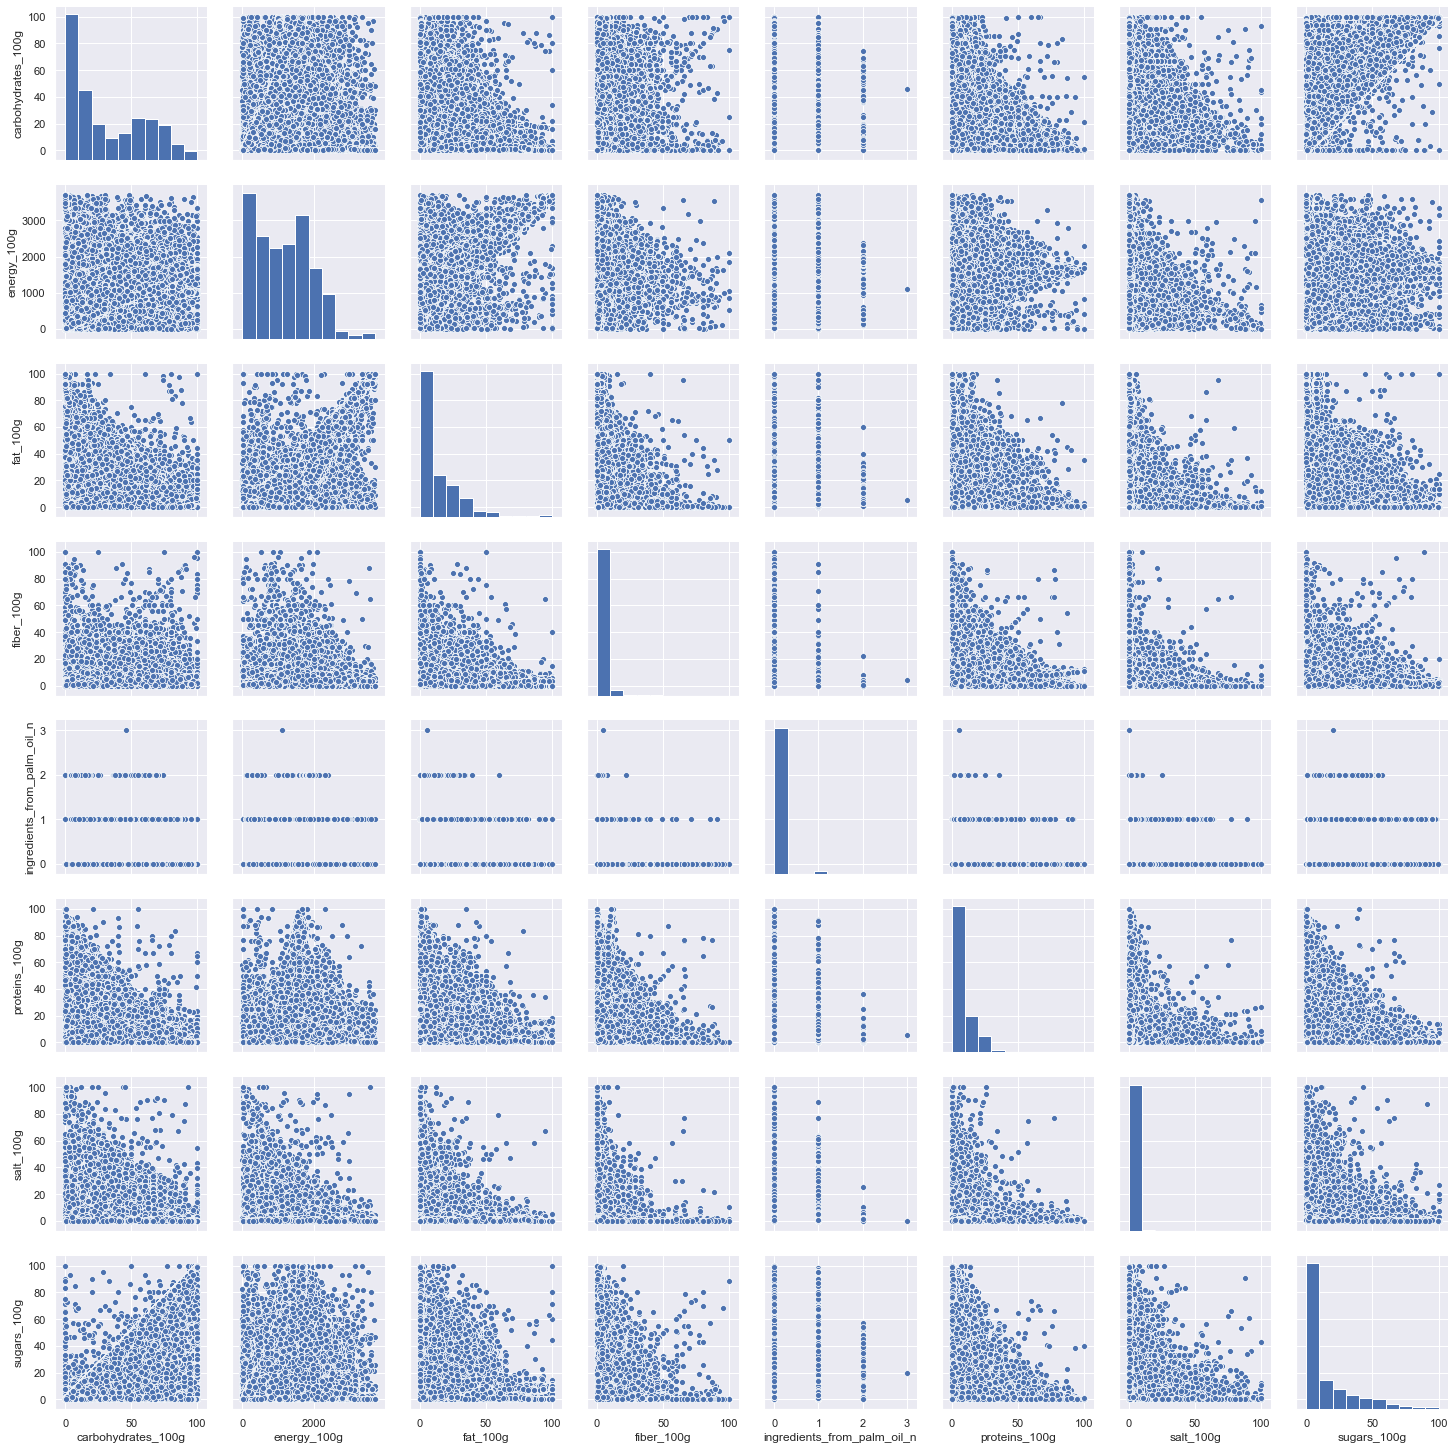

In [45]:
%config InlineBackend.figure_format = 'png' 
sns.pairplot(df_nan[['carbohydrates_100g', 'energy_100g','fat_100g','fiber_100g','ingredients_from_palm_oil_n','proteins_100g','salt_100g', 'sugars_100g']] );


#### - Suppression des valeurs aberrantes en utilisant l'écart inter quartile.

Comme la distribution des variables nutritives n'est pas normale, on se permet d'élargir les critères de suppression au delà de 1.5 *IQR afin d'enlever le maximum de valeurs aberrantes.

In [46]:
for col in liste_100g:
    #sns.boxplot(x=df_nan[col])
    # Calcul des identifiants IQR interquartile
    Q1 = df_nan[col].quantile(0.25)
    Q3 = df_nan[col].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range
    #Detect outliers
#    df_nan_outlier_IQR_a = df_nan[(df_nan[col] < Q1-1.5*IQR ) | (df_nan[col] > Q3+1.5*IQR)][col]
    df_nan_outlier_IQR_a = df_nan[ df_nan[col] > Q3+ 5*1.5*IQR ][col]

    print( "{0} : {1}".format(col , df_nan_outlier_IQR_a.shape) )
    #remove outliers
    filter = df_nan[col] <= Q3 + 5*1.5*IQR
    df_nan.loc[filter] 
    

fat_100g : (0,)
carbohydrates_100g : (0,)
sugars_100g : (0,)
fiber_100g : (2514,)
proteins_100g : (360,)
salt_100g : (5808,)


In [47]:
2514 + 360  + 5808 

8682

In [48]:
df_nan.shape

(568220, 16)

In [49]:
568220/df.shape[0]*100

40.02411787328819

Après nettoyage, on garde 40% du jeu de données pour effectuer l'analyse.

### Dict for countries 

Dans la même stratégie d'analyse de données, l'idée est de comprendre l'effet des pays sur les aliments. Pour cela, un nettoyage de la variables "countries" s'est avéré indispensable en utilisant un dictionnaire et ne gardant que le premier élément de la colonne pour éviter les redondances.

In [50]:
dict = {'US': 'Etats Unis', 'USA': 'Etats Unis', 'United States':'Etats Unis', 'us': 'Etats Unis', 'usa': 'Etats Unis',
        'Deutschland': 'Allemagne', 'en:Germany':'Allemagne', 'Germany':'Allemagne', 'Belgium' : 'Belgique',
         'Switzerland': 'Suisse', 'switzerland': 'Suisse', 'España':'Espagne', 'Spain':'Espagne','spain':'Espagne', 'Spanien':'Espagne',
        'United Kingdom':'Royaume-Uni', 'en:gb':'Royaume-Uni', 'en:United Kingdom':'Royaume-Uni','gb':'Royaume-Uni',
         'en:United States':'Etats Unis' , 'fr':'France', 'en:france':'France', 'Frankreich': 'France',
        'Francia':'France', 'en:France':'France'
       }

# Garder seulement la première valeur cad le premier pays pour éviter la redondance
df_nan['countries'] = df_nan['countries'].str.split(',').str.get(0).replace(dict)

# 2 - Analyse univariée et multivariée

## 2.1 - Création de la fonction catégorie 

L'idée est de regrouper les aliments selon des catégories plus parlantes pour les statistiques. Au total, on acréé 20 : legumes- fuits- boisson - alcool- huile- beurre- fruits à coque - sucrerie (gateau, chocolat, bonbon, ice cream)-pates- riz-fromage - creme - yaourt - lait - Oeuf- viande - poulet. 

In [51]:
def f_category(row):
    ''' f_category permet de détecter si les lignes contiennent des composants categories '''
    #-----------Legumes-------------------
    if 'legumes' in  row :
        val = 'legumes'
    elif 'brocoli' in  row :
        val = 'legumes' 
    elif 'concombre' in  row :
        val = 'legumes'
    elif 'chou' in  row :
        val = 'legumes'
    elif 'courgette' in  row :
        val = 'legumes'
    elif 'artichaut' in  row :
        val = 'legumes'
    elif 'tomate' in  row :
        val = 'legumes'
    elif 'lentille' in  row :
        val = 'legumes'
    #-----------fruits-------------------
    elif 'fruits' in  row :
        val = 'fruits'
    #-----------boisson/(jus)/ Smoothie-------------------
    elif 'boisson' in  row :
        val = 'boisson'
    elif 'jus' in  row :
        val = 'boisson'
    elif 'smoothie' in  row :
        val = 'boisson'
    elif 'Cocktail' in  row :
        val = 'boisson'
    elif 'Eau aromatisée' in  row :
        val = 'boisson'
    #-----------alcool-------------------
    elif 'vin ' in  row  :
        val = 'alcool'
    elif 'champagne' in  row  :
        val = 'alcool'
    elif 'bière' in  row :
        val = 'alcool'
    elif 'vodka' in  row :
        val = 'alcool'
    elif 'eau de vie' in  row :
        val = 'alcool'
    #-----------huile-------------------
    elif 'huile' in  row :
        val = 'oeuf'
    #-----------beurre-------------------
    elif 'beurre' in  row :
        val = 'beurre'
    #-----------fruits à coque-------------------
    elif 'noix' in  row :
        val = 'fruits secs'
    elif 'amandes' in  row :
        val = 'fruits secs'
    elif 'noisettes' in  row  :
        val = 'fruits secs'
    elif 'pistache' in  row  :
        val = 'fruits secs'
    elif 'cacahuète' in  row :
        val = 'fruits secs'
    #----------- sucreries-------------------
    elif 'chocolat' in  row :
        val = 'chocolat'
    elif 'choco' in  row :
        val = 'chocolat'
    elif 'gateau' in  row :
        val = 'gateau'
    elif 'ice cream' in  row :
        val = 'ice cream'
    elif 'tarte' in  row :
        val = 'gateau'
    elif 'viennoiserie' in  row :
        val = 'gateau'
    elif 'crêpe' in  row :
        val = 'gateau'
    elif 'pâtisserie' in  row :
        val = 'gateau'
    elif 'madeleines' in  row :
        val = 'gateau'
    elif 'biscuit' in  row :
        val = 'gateau'
    elif 'cookie' in  row :
        val = 'gateau'
    elif 'bonbon' in  row :
        val = 'bonbon'
    #-----------fromage-------------------
    elif 'fromage' in  row :
        val = 'fromage'
    #-----------creme-------------------
    elif 'creme' in  row :
        val = 'creme'
    #-----------yaourt-------------------
    elif 'yaourt' in  row :
        val = 'yaourt'
    #-----------lait-------------------
    elif 'creme' in  row :
        val = 'creme'
    #-----------Oeuf-------------------
    elif 'oeuf' in  row :
        val = 'oeuf'
    #-----------Poisson-------------------
    elif 'poisson' in  row  :
        val = 'poisson'
    elif 'sardine' in  row :
        val = 'poisson'
    elif 'thon' in  row :
        val = 'poisson'
    elif 'anchois' in  row :
        val = 'poisson'
    elif 'saumon' in  row :
        val = 'poisson'
    elif 'creuvettes' in  row :
        val = 'poisson'
    elif 'fruits de mer' in  row :
        val = 'poisson'
    #-----------Poulets-------------------
    elif 'poulet' in  row :
        val = 'poulet'
    elif 'dinde' in  row :
        val = 'poulet'
    elif 'volailles' in  row :
        val = 'poulet'
    #-----------viande------------------- 
    elif 'viande' in  row :
        val = 'viande'
    elif 'jambon' in  row :
        val = 'viande'
    elif 'cuisse' in  row :
        val = 'viande'
    #-----------pâtes------------------- 
    elif 'pâtes' in  row :
        val = 'pâtes'
    #-----------riz------------------- 
    elif 'riz' in  row :
        val = 'riz'
    else:
        val = 'unknown'
    return val

In [52]:
# A travers le "product_name" rajouter une colonne qui contient la catégorie des aliments
df_nan['categories'] = df_nan.apply(lambda x: f_category ( str (x['product_name']).lower() ),axis=1)

In [53]:
print ('Nb échantillons de catégories = {0}'.format(df_nan [df_nan['categories']!='unknown'].shape[0]))


Nb échantillons de catégories = 110368


## 2.2 - Analyse univariée

#### - Classement des produits selon le pnn_group 

Pour commencer, une exploration des nutrimements les plus répandus.

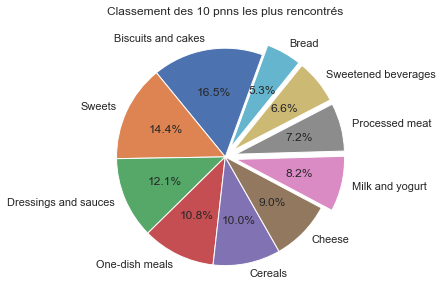

In [54]:
# Les 10 pnns les plus rencontrés
tab1= df_nan['pnns_groups_2'][ ~(df_nan['pnns_groups_2'] =='unknown')].value_counts().sort_values(ascending = False).head(10)

labels= tab1.index
plt.pie([tab1.values],labels=labels, autopct='%1.1f%%' , startangle=70, explode=(0,0,0,0,0,0,0.1,0.1,0.1,0.1))
plt.title('Classement des 10 pnns les plus rencontrés')
plt.savefig('./Pics/classement_pnn', dpi=400)
plt.show()

#### -  Distribution nutriscore des  pnn_group 

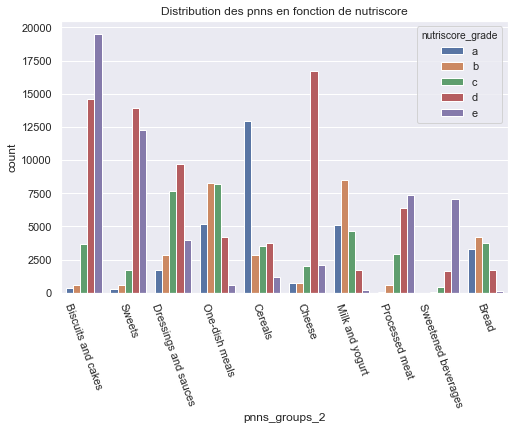

In [55]:
# Récupérer un df contenant les pnns les plus utilisés
top_pnns = df_nan['pnns_groups_2'][ (df_nan['pnns_groups_2'] !='unknown')].value_counts().sort_values(ascending = False).head(10).index.values
df_top_pnns = df_nan[df_nan['pnns_groups_2'].isin(top_pnns)]

x4 =sns.countplot(x=df_top_pnns['pnns_groups_2'], hue=df_top_pnns['nutriscore_grade'],
                  hue_order=['a','b','c','d', 'e'], 
                  order =df_nan['pnns_groups_2'][ (df_nan['pnns_groups_2'] !='unknown')].value_counts().sort_values(ascending = False).head(10).index);
x4.set_xticklabels(x4.get_xticklabels() , rotation=-70)
x4.set(title="Distribution des pnns en fonction de nutriscore")
figure = x4.get_figure()    
figure.savefig('./Pics/pnn_nutriscore', dpi=400)

- Le graphe montre que la majorité des produits les plus répandus sont de mauvaise qualité nutritive.   
- Les produits laitiers, les céréales et le pain possèdent de bons grades.  

** <u> <I>Hypothèse (1)</I></u>:  Les produits possèdant le bon score nutritionnels contiennent moins de produits transformés, additifs et l'huile de palme.  
** <u> <I>Hypothèse (2)</I></u>: Les produits possèdant le mauvais score nutritionnel proviennent des sucreries, gras.

#### -  Distribution NOVA pour les produits transformés des  pnn_group 

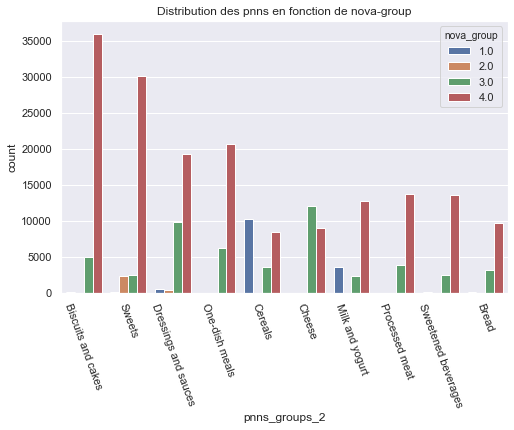

In [56]:
top_pnns = df_nan['pnns_groups_2'][ (df_nan['pnns_groups_2'] !='unknown')].value_counts().sort_values(ascending = False).head(10).index.values
df_top_pnns = df_nan[df_nan['pnns_groups_2'].isin(top_pnns)]

x4 =sns.countplot(x=df_top_pnns['pnns_groups_2'], hue=df_top_pnns['nova_group'],
                  #hue_order=['a','b','c','d', 'e'], 
                  order =df_nan['pnns_groups_2'][ (df_nan['pnns_groups_2'] !='unknown')].value_counts().sort_values(ascending = False).head(10).index);
x4.set_xticklabels(x4.get_xticklabels() , rotation=-70)
x4.set(title="Distribution des pnns en fonction de nova-group")
figure = x4.get_figure()    
figure.savefig('./Pics/pnn_nova_group', dpi=400)

La comparaison de ce graphe avec le graphe précédent montre une corrélation: Les produits détenant plus de produits transformés sont ceux qui possèdent de mauvais nutriscore et inversement.

Le graphe indique que les sucreries sont à la tête des produits transformés suivis par tout ce qui est gras (fruits secs, sauces).  
** <u> <I>Hypothèse (2)</I></u>:   Les sucreries et les gras les principaux nutriments à affecter le nutrigrade.  

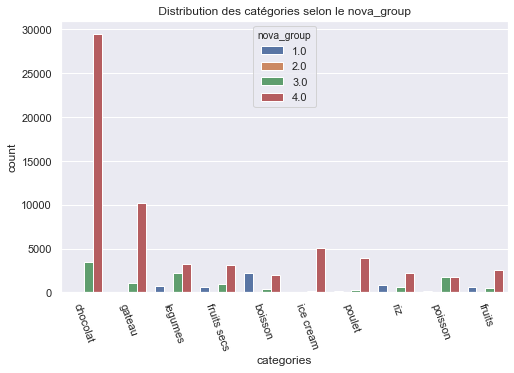

In [79]:
top_categories = df_nan['categories'][df_nan['categories']!='unknown'].value_counts().sort_values(ascending = False).head(10).index.values
df_top_categories = df_nan[df_nan['categories'].isin(top_categories)]

x4 =sns.countplot(x=df_top_categories['categories'][df_nan['categories']!='unknown'], hue=df_top_categories['nova_group'] ,
                  #hue_order=['1','2','3','4'] ,
                  order =df_nan['categories'][df_nan['categories']!='unknown'].value_counts().sort_values(ascending = False).head(10).index);

x4.set_xticklabels(x4.get_xticklabels() , rotation=-70)
x4.set(title=" Distribution des catégories selon le nova_group ")
figure = x4.get_figure()    
figure.savefig('./Pics/categories_nova_group', dpi=500)

Avec mon échantillon de catégories, je retrouve la même synthèse qu'avec le ppn.

#### -  Distribution des produits selon les additifs

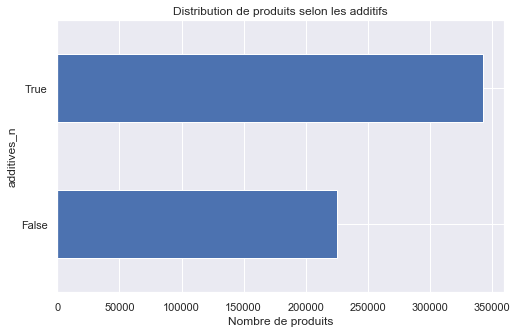

In [58]:
#perc=df_nan['additives_n'].value_counts().sort_values(ascending = False).head(5)
# Regrouper les additifs en deux catégories contient ou ne contient pas
perc=df_nan["additives_n"].groupby(df_nan["additives_n"]!=0).count()
perc.plot(kind='barh');
plt.ylabel('additives_n')
plt.xlabel('Nombre de produits')
plt.title('Distribution des produits selon les additifs')
plt.savefig('./Pics/additifs', dpi=400)


Le nombre de produits avec additifs est supérieur au nombre de produits sans additifs. Ceci confirme notre hypothèse.

In [59]:
# Coefficient de corrélation de Pearson: proche de -1 et 1. (corrélation linéaire), sinon 0
#import scipy.stats as st

j= df_nan[  pd.notnull(df_nan['nova_group'])   ]

print ('Coefficient de  corrélation de Pearson = {0}'.format( st.pearsonr(j["additives_n"],j['nova_group'])[0] ) )

Coefficient de  corrélation de Pearson = 0.4098443495551901


--->Le coefficient de corrélation de Pearson est proche de 0.4 donc additives-n et nova_group sont corrélés linéairement.   

#### -  Distribution des produits selon la composition en ingédients de l'huile de palme

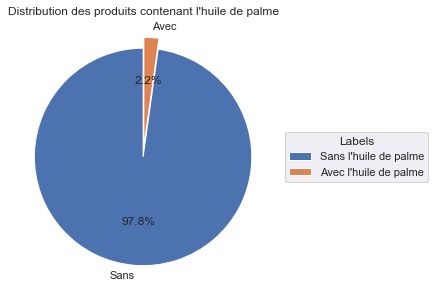

In [60]:
# Regroupers les ingrédients contenant ou ne contenant pas l'huile de palme
tab2=df_nan["ingredients_from_palm_oil_n"].groupby(df_nan["ingredients_from_palm_oil_n"]!=0).count()

labels= ['Sans', 'Avec']#(false / True)
plt.pie(tab2,labels=labels,autopct='%1.1f%%', startangle=90, explode= (0, 0.1))
plt.legend( ['Sans l\'huile de palme' , 'Avec l\'huile de palme'] ,
          title="Labels",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribution des produits contenant l\'huile de palme')
plt.savefig('./Pics/huile_de_palme', dpi=400)
plt.show()

La majorité des produits ne contiennent pas de l'huile de palme bien qu'ils soient de mauvaise qualité. Ceci indique qu'il y a d'autres nutriments qui y sont responsables.

#### ** <u> <I>Hypothèse (2)</I></u>:   Les sucreries et les gras les principaux nutriments à affecter le nutrigrade.  

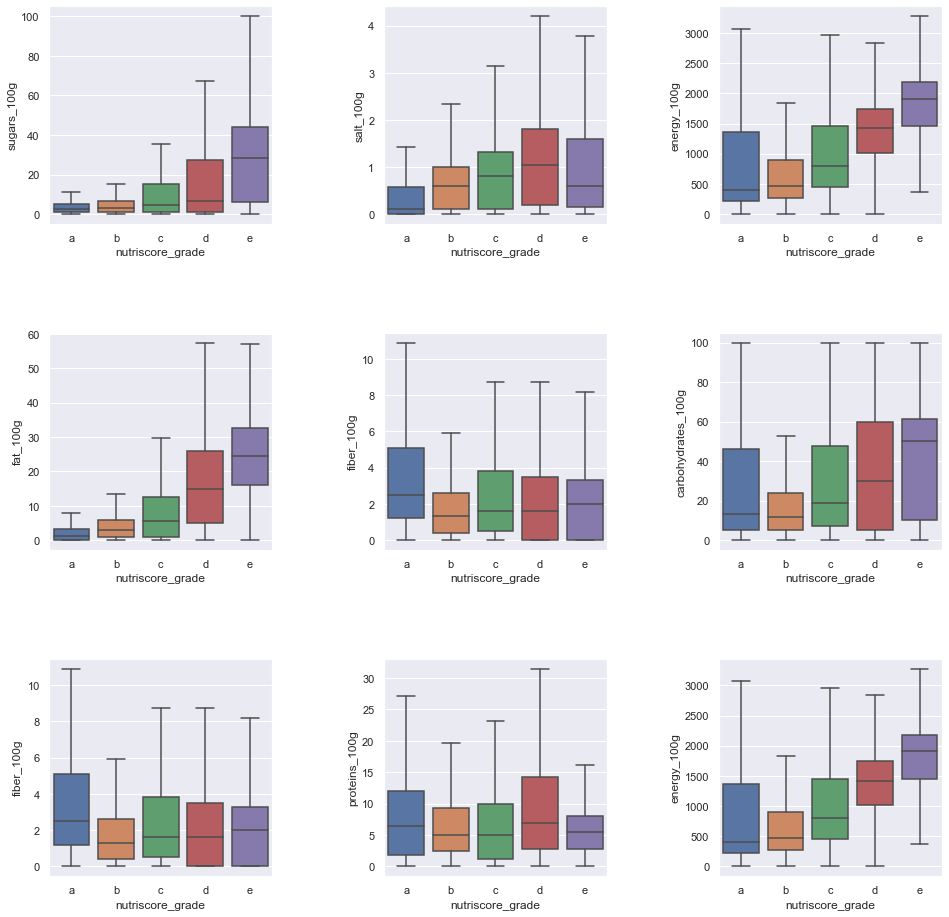

In [61]:
fig, axs = plt.subplots(3,3, figsize=(16,16) , gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

sns.boxplot(x="nutriscore_grade", y="sugars_100g", data=df_nan, showfliers=False,
                  order = ['a', 'b','c','d' ,'e'], ax=axs[0,0])
sns.boxplot(x="nutriscore_grade", y="salt_100g", data=df_nan, showfliers=False,
                  order = ['a', 'b','c','d' ,'e'], ax=axs[0,1])
sns.boxplot(x="nutriscore_grade", y="energy_100g", data=df_nan, showfliers=False,
                  order = ['a', 'b','c','d' ,'e'], ax=axs[0,2])

sns.boxplot(x="nutriscore_grade", y="fat_100g", data=df_nan, showfliers=False,
                  order = ['a', 'b','c','d' ,'e'], ax=axs[1,0])
sns.boxplot(x="nutriscore_grade", y="fiber_100g", data=df_nan, showfliers=False,
                  order = ['a', 'b','c','d' ,'e'], ax=axs[1,1])
sns.boxplot(x="nutriscore_grade", y="carbohydrates_100g", data=df_nan, showfliers=False,
                  order = ['a', 'b','c','d' ,'e'], ax=axs[1,2])

sns.boxplot(x="nutriscore_grade", y="fiber_100g", data=df_nan, showfliers=False,
                  order = ['a', 'b','c','d' ,'e'], ax=axs[2,0])
sns.boxplot(x="nutriscore_grade", y="proteins_100g", data=df_nan, showfliers=False,
                  order = ['a', 'b','c','d' ,'e'], ax=axs[2,1])
sns.boxplot(x="nutriscore_grade", y="energy_100g", data=df_nan, showfliers=False,
                  order = ['a', 'b','c','d' ,'e'], ax=axs[2,2])
fig.savefig('./Pics/boxplot_nutriments', dpi=400)

Selon les boites à moustaches, tout ce qui est sucré, gras, salé présente un mauvais indice nutrigrade. Les indicateurs nutritionnels qui présentent une bonne qualité comportent les fibres et les protéines. Quant aux glucides, ils présentent autant d'indices sains que mauvais ce qui confirme qu'il y a de bons et de mauvais glucides.

#### -  Catégories riches en graisse et en glucide

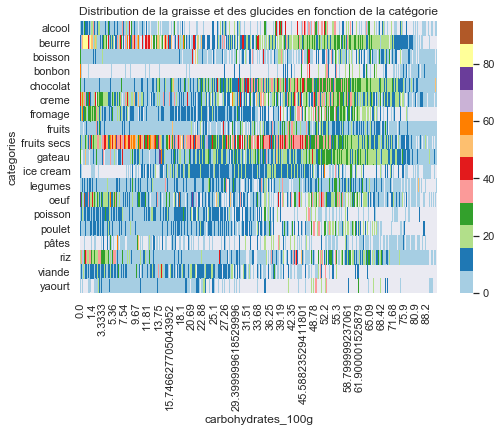

In [62]:
heatmap1_data = pd.pivot_table(df_nan[ (df_nan['categories'] !='unknown')],
                     values='fat_100g', 
                     index=['categories'], 
                     columns='carbohydrates_100g')
colormap = plt.cm.Paired #plt.cm.cubehelix_r
ax = sns.heatmap(heatmap1_data, cmap=colormap )
 
ax.set(title="Distribution de la graisse et des glucides en fonction de la catégorie")
figure = ax.get_figure()    
figure.savefig('./Pics/graisse_glucide', dpi=400)

Le graphe indique que les glucides se retrouvent dans le riz, sucreries, fruits et les boissons. Tandis que la graisse est plus présente dans les fruits secs, oeuf, viande, beurre, quelques sucrerie telle que chocolat et certains produits laitiers telle que la crème. 

### -  Analyse multivariée explicative (ANOVA)

#### - Vérification de la corrélation des ingrédients avec nutrigrade

In [63]:
#------------Analyser une variable quantitative et une qualitative par ANOVA---------
# Analyse de la variance selon le modèle ANalysis Of VAriance (ANOVA)

#______  eta_squared =0  --->  moyennes/classe égales   --->  Pas de relation entre X & Y

#______  eta_squared =1  --->  moyennes/classe différentes   --->  Relation entre X & Y


def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    


In [64]:
'''Fonction pour automatiser l'appel de l analyse ANOVA'''

X = "nutriscore_grade" # qualitative
#Y  # quantitative
sample= df_nan[  pd.notnull(df_nan['nutriscore_grade'])   ]

#______  eta_squared =0  --->  moyennes/classe égales   --->  Pas de relation entre X & Y

#______  eta_squared =1  --->  moyennes/classe différentes   --->  Relation entre X & Y

#---  fat ---fibre--- salt--- sugar --- carbohydrates--
print (" Rapport de corrélation entre: " )
for col in liste_100g: 
    print("- nutriscore_grade  & {0} = {1}".format( col, eta_squared(sample[X],sample[col]) ) )   



 Rapport de corrélation entre: 
- nutriscore_grade  & fat_100g = 0.21006534344926198
- nutriscore_grade  & carbohydrates_100g = 0.058356750951968434
- nutriscore_grade  & sugars_100g = 0.18132652479727404
- nutriscore_grade  & fiber_100g = 0.036322071585198186
- nutriscore_grade  & proteins_100g = 0.014643269651213799
- nutriscore_grade  & salt_100g = 0.03336684032895511


Les rapports de corrélation ANOVA du sel, protéines, fibres et glucides par rapport à nutrigrade sont faibles, justifiant ainsi d'une faible corrélation.  
Par contre, la qualité nutritionnelle est affectée par la graisse puis les sucres ce qui confirme l'hypothèse 2.


#### - Produits contenant le plus de gras


Il est intéressant dans la suite de l'étude de vérifier quels sont les pays qui produisent ces produits alimentaires nocifs à la santé et d'en déterminer les pnns. Les graphes suivants montrent que les Etats-Unis et la France sont à la tête des pays produisant le plus de produits alimenttaires nocifs à la santé. Ceci s'explique aussi par l'origine des aliments qui ont permi de constituer ce jeu de données. La distribution des pnns selon les composants gras et sucrés est logique.

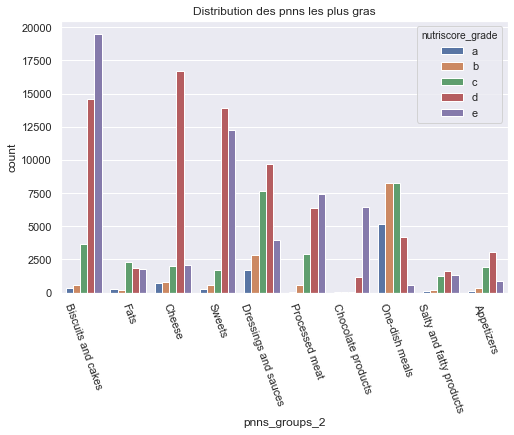

In [65]:
#Récupération des produits qui sont les plus gras : groupement par les catégories de pnns_groups_2
top_gras_pnns= df_nan.groupby("pnns_groups_2")["fat_100g"].sum().sort_values(ascending=False).head(11).index.values
top_gras_pnns=top_gras_pnns [top_gras_pnns!=('unknown')]
df_top_gras = df_nan[ df_nan['pnns_groups_2'].isin(top_gras_pnns)]

x4 =sns.countplot(x=df_top_gras['pnns_groups_2'],
                  hue=df_top_gras['nutriscore_grade'], hue_order=['a','b','c','d', 'e'], 
                  order = top_gras_pnns);
x4.set_xticklabels(x4.get_xticklabels() , rotation=-70)
x4.set(title="Distribution des pnns les plus gras")
figure = x4.get_figure()    
figure.savefig('./Pics/pnns_les_plus_gras', dpi=400)

#### - Pays produisant le plus de gras


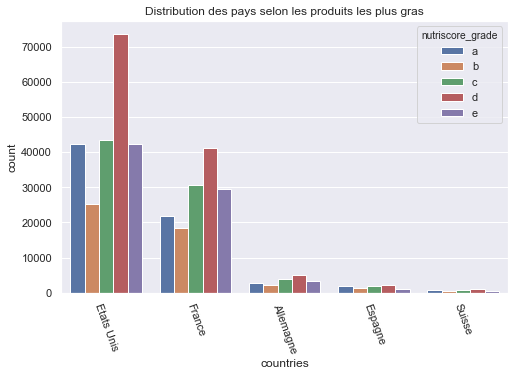

In [66]:
#Récupération des pays qui détiennent le plus de gras dans leurs aliments : groupement par les catégories de pnns_groups_2


#top contries selon fat_100g
top_fat_countries = df_nan.groupby("countries")["fat_100g"].sum().sort_values(ascending=False).head(5).index.values
df_top_fat = df_nan[ df_nan["countries"].isin (top_fat_countries)]

x4 =sns.countplot(x=df_top_fat['countries'],
                  hue=df_top_fat['nutriscore_grade'], hue_order=['a','b','c','d','e'], 
                  order = top_fat_countries 
                 );
x4.set_xticklabels(x4.get_xticklabels() , rotation=-70)
x4.set(title="Distribution des pays selon les produits les plus gras")
figure = x4.get_figure()    
figure.savefig('./Pics/pays_les_plus_gras', dpi=400)

#### - Produits contenant le plus de sucre

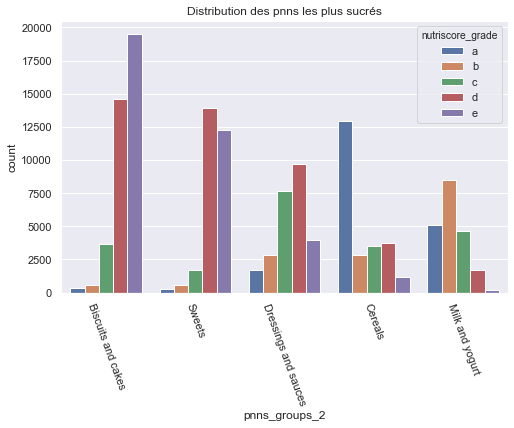

In [67]:
#Récupération des produits qui sont les plus sucrés : groupement par les catégories de pnns_groups_2


top_sucre_pnns= df_nan.groupby("pnns_groups_2")["sugars_100g"].sum().sort_values(ascending=False).head(11).index.values
top_sucres_pnns=top_sucre_pnns [top_sucre_pnns!=('unknown')]
df_top_sucre = df_nan[ df_nan['pnns_groups_2'].isin(top_sucre_pnns)]


x4 =sns.countplot(x=df_top_sucre['pnns_groups_2'],
                  hue=df_top_sucre['nutriscore_grade'], hue_order=['a','b','c','d', 'e'], 
                  order =df_top_sucre['pnns_groups_2'][ (df_top_sucre['pnns_groups_2'] !='unknown')].value_counts().sort_values(ascending = False).head(5).index);
x4.set_xticklabels(x4.get_xticklabels() , rotation=-70)
x4.set(title="Distribution des pnns les plus sucrés")
figure = x4.get_figure()    
figure.savefig('./Pics/pnns_les_plus_sucres', dpi=400)

#### - Pays produisant le plus de sucre 

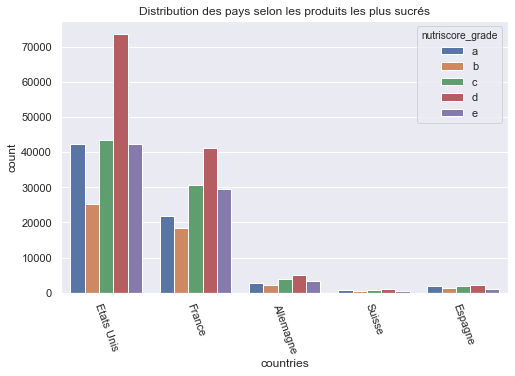

In [68]:
#Récupération des pays qui détiennent le plus de sucreries dans leurs aliments : groupement par les catégories de pnns_groups_2

top_sucre_countries = df_nan.groupby("countries")['sugars_100g'].sum().sort_values(ascending=False).head(5).index.values
df_top_sucre = df_nan[df_nan['countries'].isin(top_sucre_countries)]

x4 =sns.countplot(x=df_top_sucre['countries'],
                  hue=df_top_sucre['nutriscore_grade'], hue_order=['a','b','c','d','e'], 
                  order = top_sucre_countries
                 );

x4.set_xticklabels(x4.get_xticklabels() , rotation=-70)
x4.set(title="Distribution des pays selon les produits les plus sucrés")
figure = x4.get_figure()    
figure.savefig('./Pics/pays_les_plus_sucres', dpi=400)

### -  La méthode d’analyse descriptive (ACP)

In [69]:
# Inclure l'énergie dans cette étude ACP
liste_100g +=['energy_100g']

#### -  Préparation des données pour l'ACP

In [70]:

from sklearn import decomposition
from sklearn import preprocessing
from functions import *

# choix du nombre de composantes à calculer
n_comp = 6

# import de l'échantillon (pas de NAN dans nutriscore_grade & nova_group)
data = df_nan[pd.notnull(df_nan['nutriscore_grade'])  & (pd.notnull(df_nan['nova_group'])) ]

# selection des colonnes à prendre en compte dans l'ACP
data_pca = data[liste_100g]



# nutriscore_grade de data_pca]

nutri =  data['nutriscore_grade']



# préparation des données pour l'ACP
X = data_pca.values
features = data_pca.columns
#names = data["code"] # ou data.index pour avoir les intitulés
#names = data["nutriscore_grade"]


# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)



PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

#### - Ebloui des valeurs propres 

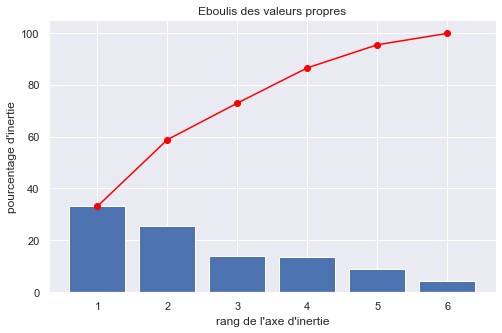

In [71]:
# Eboulis des valeurs propres
display_scree_plot(pca)

A travers le graphe "ébloui des valeurs propres", l'utilisation des trois premières composantes principales (F1, F2 et F3) dépasse  70% du pourcentage d'inertie. Ce taux d'inertie donne une bonne projection des variables (colonnes) et des individus (échantillon).  

En pratique, le choix s'effectue la plupart du temps sur les deux premières composantes principales et dans notre cas on obtient un taux d'inertie de 60% avec le premier plan factoriel. Cela conserve la qalité de projection des données.

Selon la règle de Kaiser:  ne pas considérer comme importants les axes dont l’inertie associée est inférieure à (100/p)%. Ici p= 7 donc choisir  des valeurs propres dont le minimum est de 0.14



#### - Cercle des corrélations 

Les flèches des variables les plus proches du cercle sont les mieux projetées.   


- Dans le Plan 1: les variables sont moyennement projetées.

De plus, les flèches entre les paires (glucides/sucres) ou (protéines/sels) ou (graisse / energie) sont dans le même sens et sont proches. Donc ces variables sont corrélées positivement. On peut donc dire que les produits ayant des valeurs élevées dans le premier nutriment, ont des teneurs élevées aussi dans le deuxième nutriment.   



De même, les flèches des fibres sont plus ou moins perpendiculaires à celles du sel. Donc ces variables ont une corrélation nulle. On peut donc dire qu’il n’y a pas de relation linéaire entre le sel et les fibres.



-- > On peut interpréter F1 comme étant les nutriments nocifs à la santé ou les nurtiments forts en calories.  

-- > On peut interpréter F2 comme étant composition en glucides (le glucide contient le sucre).



- Dans le Plan 2: Les flèches entre la teneur en Fibre et en Protéine contre la teneur en  Energie et Graisse sont de sens opposé. Donc ces variables sont corrélées négativement. On peut donc dire que les produits ayant des valeurs énergétiques et graisse élevées, ont une teneur en Fibre et Protéine faible.  


-- > On peut interpréter F3 comme étant composition calorique faible.


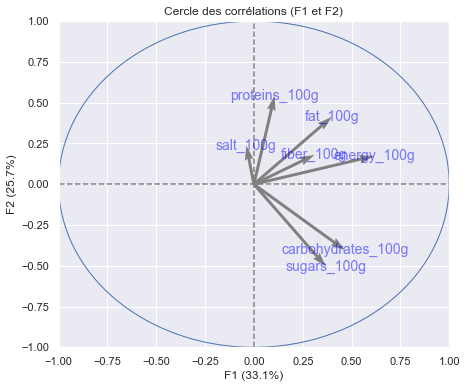

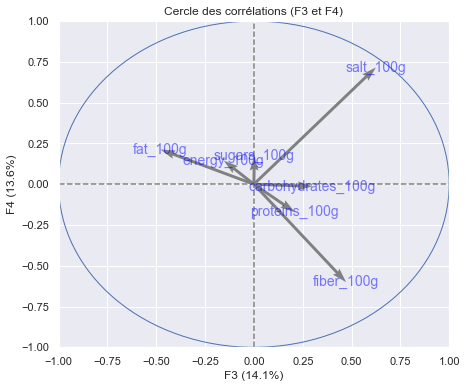

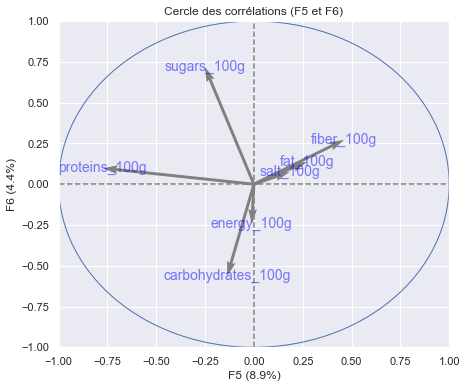

In [72]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))


#### - Projection des individus

- <u> Pour le plan P1 </u>: La majorité des nutriments ont des valeurs nutritives entre e puis d et c ce qui prouve qu'ils sont nocifs pour la santé. On retrouve la valeur b autour du fibre et des protéines qui sont effectivement des nutriments plus sains.   

- <u>Pour le plan P2</u>: l'indice nutritif e est le plus répandu suivi par d et tous deux correspondent à des aliments non sains. On ressence le gras, l'energie, le sucre et les glucides dans cette partie de la projection.  

- Le fibre présente des indices nutritifs entre a et b ce qui prouve qu'il est bon pour la santé.   

- Par contre pour le sel, c'est l'indice d et donc il est nocif pour la santé.

- <u>Pour le plan P3</u>: On retrouve la même distribution des indices nutritionnels sur les aliments que sur le plan P2.

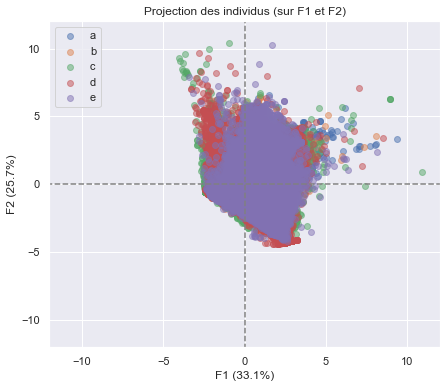

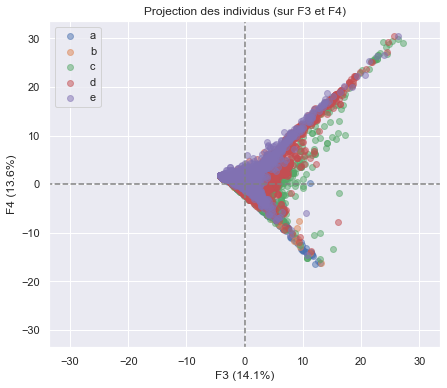

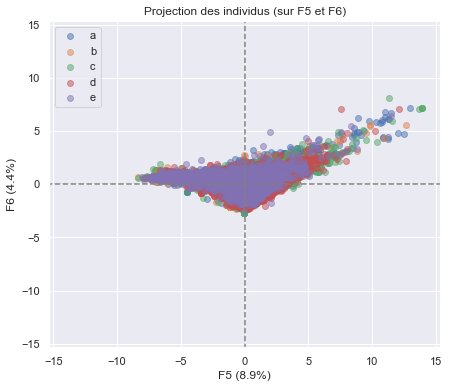

In [73]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], illustrative_var = nutri, alpha = 0.5)

plt.show()

#### -Utiliser pairplot 

In [74]:
df_pca =pd.DataFrame(X_projected, columns=['ACP%i' % (i+1) for i in range(n_comp)], index=data.nutriscore_grade)
df_pca['nutri'] = df_pca.index


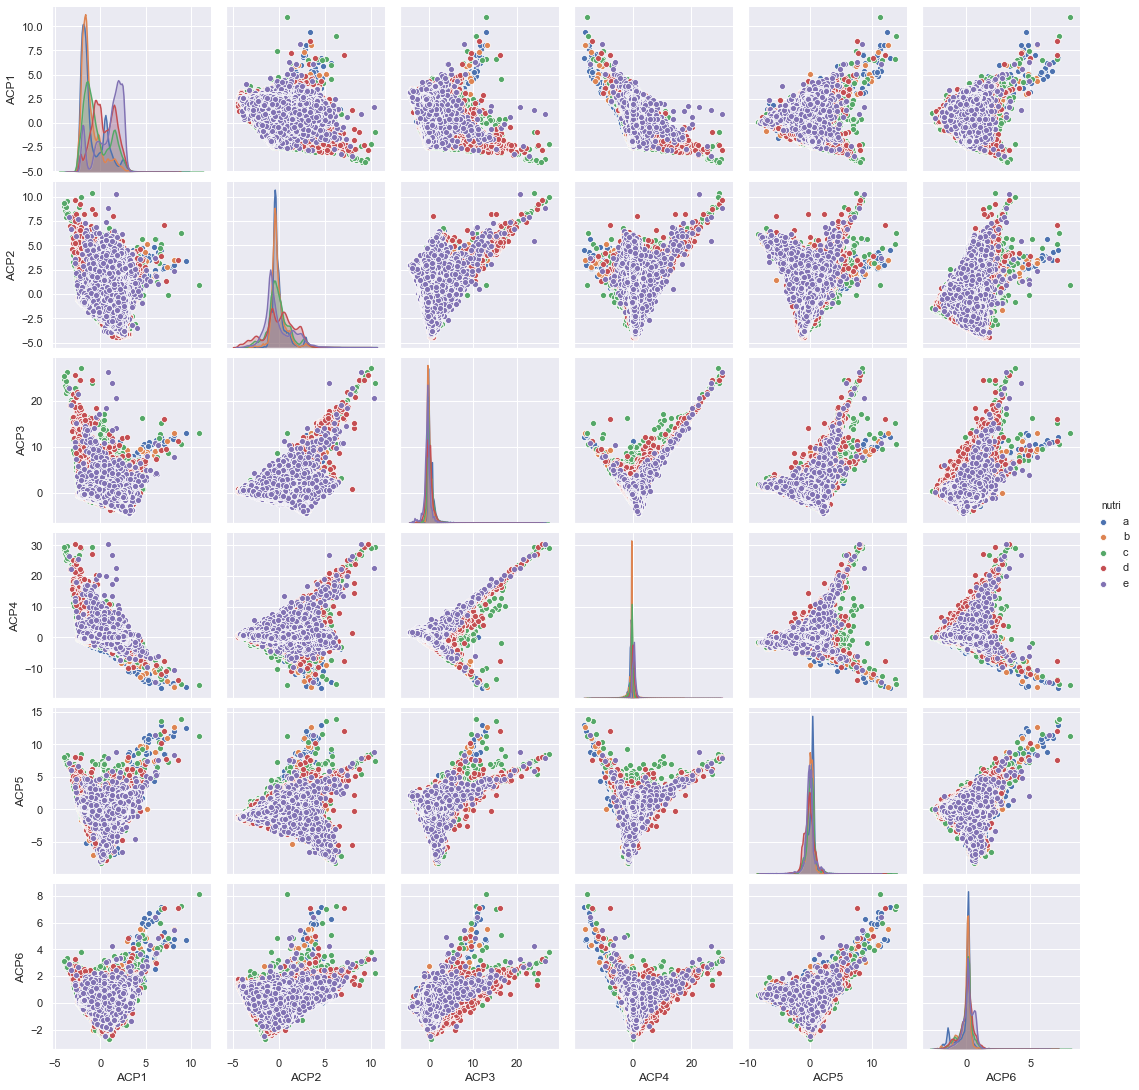

In [75]:
x6=sns.pairplot(df_pca, hue = 'nutri', hue_order= ['a','b','c','d','e'])
x6.savefig('./Pics/ACP_pairplot', dpi=400)

Ce pairplot des composantes de l'ACP illustre la formation de groupes selon les cinq catégories nutritionnelles "nutriscore_grade". Le groupe avec la classification e est le plus répandu, suivi de d et c.

### Sauvegarde d'un sous échantillon dans csv

Enregistrer un échantillon de 10 000 entrées ne contenant qucune valeur nulle dans un fichier csv pour l'utilisation de Voila comme outil de visalisation du protoypage.

In [76]:
ech=df_nan.dropna()[:10000]


In [77]:
ech.to_csv("sample.csv",sep="\t", index=False)

In [78]:
#Lescture du fichier csv
#cc=  pd.read_csv('sample.csv', sep='\t')